# Metadata Analysis of the Papers of Conrad Hal Waddington Collection (Coll-41)

View in the online catalogue, ArchivesSpace, at: https://archives.collections.ed.ac.uk/repositories/2/resources/85257

#### Collection Overview
The Papers of Conrad Hal Waddington (Coll-41) is a collection catalogued and maintained by Edinburgh University Library Archives.  The Archives contains an estimated 6 linear kilometers of material (such as manuscripts, photographs, notebooks, to name a few); Coll-41 accounts for 11.4 linear meters.  The Archives does not know the exact date it acquired Coll-41, though it estimates receiving it around 1978.  The metadata available for Coll-41 was written for the Archives catalogue over a period of six months, from April to October 2012. Cataloguing was completed in accordance with an international standard for archival metadata, the ISAD(G), which organizes collection metadata hierarchically.  Coll-41 contains material dating from his time as a student at Clifton College and Sidney Sussex College through to his death in 1975.

#### Background on the Collection's Creator, Conrad Hal Waddington
Conrad Hal Waddington was born in 1905 in England.  He became an embryologist and developmental biologist, working at various points of his life as a lecturer, operational researcher (in the Royal Air Force), a scientific advisor (to the Coastal Command), an author, and leadership positions in genetics at the University of Edinburgh.  His work contributed to the development of systems biology, a holistic approach to studying interactions among biological systems. His interests included not only science, but also art, philosophy, and sociology, which the material in Coll-41 reflects.  Waddington died in 1975.

#### Sources
* The University of Edinburgh.  2016.  *Directory of Collections.*  Third Millenium Publishing, pp. 186-7.
* Breitling R. (2010). What is systems biology?. Frontiers in physiology, 1, 9. https://doi.org/10.3389/fphys.2010.00009

## 1. Parsing

In [196]:
# Libraries to get XML data through OAI Harvesting
import xml.etree.ElementTree as ET
import urllib.request

# Libraries for data analysis and visualization
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import mode

# Libraries for Natural Language Processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.text import Text
nltk.download('punkt')
from nltk.probability import FreqDist
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from nltk.draw.dispersion import dispersion_plot
from nltk.collocations import BigramAssocMeasures
from nltk.collocations import BigramCollocationFinder
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag

# Other useful libraries
import string
import csv
import re


[nltk_data] Downloading package punkt to /usr/local/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Use OAI Harvesting to fetch the collection from ArchivesSpace by its identifier:

In [2]:
waddingtonUrl = "http://lac-archives-live.is.ed.ac.uk:8082/?verb=GetRecord&metadataPrefix=oai_ead&identifier=oai:archivesspace//repositories/2/resources/85257"

Parse the metadata (xml) for that collection:

In [3]:
content = urllib.request.urlopen(waddingtonUrl)
waddingtonTree = ET.parse(content)

ElementTree stores xml data in a hiearachical (tree) structure.  The root is the top node of the tree and all subnodes are the children of the tree.  Each xml tag and attribute are accessbile from the root and children with tag and attrib methods.  Children are also accessible by index.

In [11]:
root = waddingtonTree.getroot()
print(str(root.text) == "None")
print(root[0].tag)
print(root[1].tag)
print(root[2][0][0][0].tag)
print(root[2][0][1][0][1][1].tag)

True
{http://www.openarchives.org/OAI/2.0/}responseDate
{http://www.openarchives.org/OAI/2.0/}request
{http://www.openarchives.org/OAI/2.0/}identifier
{urn:isbn:1-931666-22-9}scopecontent


**Note: The tag names are not the same as they appear in the XML viewed in a web browser!**



I'm interested in the text between the tags because that's the information cataloguers fill in to describe the collection.
*documentation resource: https://docs.python.org/3/library/xml.etree.elementtree.html#xml.etree.ElementTree.Element.iter*

In [5]:
waddington_text = []
unique_waddington_text = []
for child in root[2].itertext():
    if child not in unique_waddington_text:
        unique_waddington_text.append(child)
    waddington_text.append(child)
print("Total metadata entries: " + str(len(waddington_text)))
print("Unique metadata entries: " + str(len(unique_waddington_text)))
print("(" + str((len(unique_waddington_text)/len(waddington_text))*100) + "%)")
print("Repeated metadata entries: " + str(len(waddington_text) - len(unique_waddington_text)))

Total metadata entries: 4823
Unique metadata entries: 2592
(53.74248393116318%)
Repeated metadata entries: 2231


#### Create Text Files
I'll write the descriptions at the fonds level (entire collection) to a text file to read with Python's NLTK:

In [100]:
with open('waddington_descriptions.txt', 'w') as f:
    total_words = 0
    for text in waddington_text:
        total_words += len(re.findall("(\w+)(-*)(\w*)", text))
        f.write(text + " ")
    f.close()
    print("Total words in file: " + str(total_words))

Total words in file: 35882


I'll also create a text file that includes only the text under the "Scope and Contents" heading as this is where most of the descriptive metadata lives (there are also descriptions under the Biographical / Historical heading):

In [36]:
# Input: part of or the entirety of a tag name below which you want to get text 
# Output: a list of text between tags contained within the inputted tagName, 
#         with one list element per tagName instance
def getTextBeneathTag(tagName, header):
    text_list = []
    for child in root.iter():
        tag = child.tag
        if tagName in tag:
            text_elem = ""
            for subchild_text in child.itertext():
                if header:
                    if header not in subchild_text:
                        text_elem = text_elem + subchild_text
                else:
                    text_elem = text_elem + subchild_text
            # replace each newline with a single space
            text_elem = " ".join(text_elem.split())
            text_list.append(text_elem)
    return text_list

# ad = getTextBeneathTag("archdesc", None)  # result has spacing errors
sc = getTextBeneathTag("scopecontent", "Scope and Contents")
bh = getTextBeneathTag("bioghist", "Biographical / Historical")

assert(len(sc) == 314)

In [41]:
# Input: the name (or file path) of the file you wish to output
#        and the name of the list (an array of strings) to write to that file
# Output: the file written where inputted and the file's wordcount
def writeFileFromList(fileName, listName):
    with open(fileName, 'w') as f:
        total_words = 0
        for text in listName:
            total_words += len(re.findall("(\w+)(-*)(\w*)", text))
            f.write(text)
    f.close()
    return str(total_words)

In [61]:
sc_words = writeFileFromList("scope_and_contents.txt", sc)
bh_words = writeFileFromList("biog_hist.txt", bh)
print("'Scope and Contents' word count: "+ str(sc_words))
print("'Biographical / Historical' word count: "+ str(bh_words))

'Scope and Contents' word count: 13801
'Biographical / Historical' word count: 6963


In [43]:
def getAllText(elem):
    all_text = []
    for node in elem.itertext():
        all_text.append(node)
    return all_text

series_text = []
subseries_text = []
item_text = []
level_tags = ["{urn:isbn:1-931666-22-9}c01", "{urn:isbn:1-931666-22-9}c02", "{urn:isbn:1-931666-22-9}c03"]
for elem in root[2].iter():
    if elem.tag in level_tags:
        if elem.attrib["level"] == "item":
            item_text += [getAllText(elem)]
        elif elem.attrib["level"] == "subseries":
            subseries_text += [getAllText(elem)]
        elif elem.attrib["level"] == "series":
            series_text += [getAllText(elem)]

# print(item_text[0])
# print()
# print(subseries_text[0])
# print()
# print(series_text[0])

assert(len(item_text) == 343)
assert(len(subseries_text) == 14)
assert(len(series_text) == 10)
# totals from assertions based on word search (ctrl+f) of xml data online

In [44]:
def createFileFromList(text_list, filetype):
    total_words = 0
    filename = filetype + ".txt"
    with open(filename, "w") as f:
        for item in text_list:
            for text in item:
                # Count the total number of words (considering hyphenated words or date ranges to be one word)
                total_words += len(re.findall("(\w+)(-*)(\w*)", text))
                text = " " + text
                f.write(text)
    f.close()
    print("Total words in file: " + str(total_words))

Create the item-level file.

*Note: all item-level descriptions are also in the subseries, series and fonds files.*

In [45]:
createFileFromList(item_text, "descByItem")

Total words in file: 31547


Calculate summary statistics of item descriptions:

In [46]:
item_desc_lengths = np.array([])
for item_desc in item_text:
    item_desc_lengths = np.append(item_desc_lengths, len(item_desc))
# print(item_desc_lengths)
assert(len(item_desc_lengths) == len(item_text))

i_mean = np.mean(item_desc_lengths)
i_std = np.std(item_desc_lengths)
i_median = np.median(item_desc_lengths)
i_mode = mode(item_desc_lengths)[0]
i_max = np.max(item_desc_lengths)
i_min = np.min(item_desc_lengths)

print("The average number of metadata fields in an item description is: " + str(i_mean))
print("The standard deviation in number metadata fields in an item description is: " + str(i_std))
print("The middle number of metadata fields among all item descriptions is: " + str(i_median))
print("The most common number of metadata fields in an item description is: " + str(i_mode))
print("The maximum number of metadata fields in an item description is: "+ str(i_max))
print("The minimum number of metadata fields in an item description is: "+ str(i_min))

The average number of metadata fields in an item description is: 12.0583090379
The standard deviation in number metadata fields in an item description is: 4.86698696888
The middle number of metadata fields among all item descriptions is: 11.0
The most common number of metadata fields in an item description is: [ 11.]
The maximum number of metadata fields in an item description is: 70.0
The minimum number of metadata fields in an item description is: 6.0


In [128]:
item_words = np.array([])
for item_desc in item_text:
    per_item = []
    sentence_words = 0
    for sentence in item_desc:
        sentence_words += len(re.findall("(\w+)(-*)(\w*)", sentence))
    item_words = np.append(item_words, sentence_words)

# print(item_words)

i_words_mean = np.mean(item_words)
i_words_std = np.std(item_words)
i_words_median = np.median(item_words)
i_words_mode = mode(item_words)[0]
i_words_max = np.max(item_words)
i_words_min = np.min(item_words)

print("The average number of words in an item description is: " + str(i_words_mean))
print("The standard deviation in number of words in an item description is: " + str(i_words_std))
print("The middle number of words among all item descriptions is: " + str(i_words_median))
print("The most common number of words in an item description is: " + str(i_words_mode))
print("The maximum number of words in an item description is: "+ str(i_words_max))
print("The minimum number of words in an item description is: "+ str(i_words_min))

The average number of words in an item description is: 91.9737609329
The standard deviation in number of words in an item description is: 56.370462559
The middle number of words among all item descriptions is: 79.0
The most common number of words in an item description is: [ 61.]
The maximum number of words in an item description is: 542.0
The minimum number of words in an item description is: 19.0


Create the subseries-level file.

*Note: all subseries-level descriptions are also in the series and fonds files.*

In [97]:
createFileFromList(subseries_text, "descBySubseries")

Total words in file: 11557


Create the series-level file.

*Note: all series-evel descriptions are also in the fonds file.*

In [98]:
createFileFromList(series_text, "descBySeries")

Total words in file: 35070


## 2. Preprocessing
Using Python NLTK: https://www.nltk.org/

### 2.1 Tokenization
#### 2.1.1 At the Fonds (Collection) Level
Read in the Waddington descriptions text file as a string:

In [44]:
f = open('waddington_descriptions.txt', 'r')
fonds_string = f.read()
f.close()
fonds_string[0:100]

[nltk_data] Downloading package punkt to /usr/local/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Tokenize and normalize (make all words lowercase) the text data:

In [46]:
fonds_tokens = word_tokenize(fonds_string)
print(fonds_tokens[0:50])

['oai', ':', 'archivesspace//repositories/2/resources/85257', '2020-01-29T16:28:32Z', 'Coll-41', 'Papers', 'of', 'Conrad', 'Hal', 'Waddington', 'Coll-41', 'Edinburgh', 'University', 'Library', 'Special', 'Collections', 'Centre', 'for', 'Research', 'Collections', 'University', 'of', 'Edinburgh', 'Main', 'Library', 'George', 'Square', 'Edinburgh', 'EH8', '9LJ', 'is-crc', '@', 'ed.ac.uk', 'URL', ':', 'This', 'finding', 'aid', 'was', 'produced', 'using', 'ArchivesSpace', 'on', '2020-05-08', '13:51:57', '+0100', '.', 'English', 'Edinburgh', 'University']


In [47]:
lower_fonds_tokens = [word.lower() for word in fonds_tokens]
print(lower_fonds_tokens[0:50])

['oai', ':', 'archivesspace//repositories/2/resources/85257', '2020-01-29t16:28:32z', 'coll-41', 'papers', 'of', 'conrad', 'hal', 'waddington', 'coll-41', 'edinburgh', 'university', 'library', 'special', 'collections', 'centre', 'for', 'research', 'collections', 'university', 'of', 'edinburgh', 'main', 'library', 'george', 'square', 'edinburgh', 'eh8', '9lj', 'is-crc', '@', 'ed.ac.uk', 'url', ':', 'this', 'finding', 'aid', 'was', 'produced', 'using', 'archivesspace', 'on', '2020-05-08', '13:51:57', '+0100', '.', 'english', 'edinburgh', 'university']


In [64]:
total_item_est = len(re.findall("Scope and Contents",waddington_string))
print("Total Scope and Contents descriptions in Coll-41:", total_item_est)
total_entity_est = len(re.findall("Biographical / Historical",waddington_string))
print("Total Biographical / Historical descriptions in Coll-41:", total_entity_est)

Total Scope and Contents descriptions in Coll-41: 314
Total Biographical / Historical descriptions in Coll-41: 159


In [49]:
print(lower_waddington_tokens.count("contents"))
print(lower_waddington_tokens.count("scope"))

315
319


#### 2.1.2 Of Description Tags

In [59]:
# Input: the name of a .txt file
# Output: the tokens, standardized to lowercase, that NLTK creates from the file
def tokenizeFromFile(fileName):
    f = open(fileName, 'r')
    f_string = f.read()
    f.close()
    f_tokens = word_tokenize(f_string)
    lower_f_tokens = [word.lower() for word in f_tokens]
    return lower_f_tokens

Tokenize the "Scope and Contents" and "Biographical / Historical" descriptions:

In [145]:
sc_tokens = tokenizeFromFile("scope_and_contents.txt")
bh_tokens = tokenizeFromFile("biog_hist.txt")

print("Scope and Contents")
print("-------------------")
print("Total tokens: " + str(len(sc_tokens)))
print("Sample: " + str(sc_tokens[:10]))
print()
print("Biographical / Historical")
print("--------------------------")
print("Total tokens: " + str(len(bh_tokens)))
print("Sample: " + str(bh_tokens[:10]))

Scope and Contents
-------------------
Total tokens: 15382
Sample: ['contains', ':', 'laboratory', 'notebooks', 'and', 'bundles', 'of', 'research', 'notes', ',']

Biographical / Historical
--------------------------
Total tokens: 7421
Sample: ['waddington', 'worked', 'with', 'joseph', 'and', 'dorothy', 'needham', 'in', 'cambridge', 'in']


In [70]:
t = Text(sc_tokens)
# t.concordance('her')  # No matches
t.concordance('his', lines=5)

Displaying 5 of 27 matches:
ollecting data on mutant strains from his colleagues , and setting them questio
ng permission to use illustrations in his own publications.the correspondence c
ersity press to reproduce the text of his book biology , purpose and ethics in 
blurb and a letter to waddington from his literary agents a.p watt & son , conf
 general editor from 1958 , following his work as general editor of the cambrid


## 3. Analyzing

### 3.1 Counting Tokens

In [80]:
# Input: the regular expression to look for and the list of tokens in which to search
# Output: the list of occurrences of the regular expression in the list of tokens 
def regExTokenSearch(regEx, tokens_to_search):
    occurrences = [o for o in tokens_to_search if re.search(regEx, o)]
    return occurrences

Look for the presence of *men/man* and *women/woman* in the 'Scope and Contents' descriptions:

In [90]:
maen_sc = regExTokenSearch('^m[ae]n$', sc_tokens)
womaen_sc = regExTokenSearch('^wom[ae]n$', sc_tokens)
print(len(maen_sc))
print(len(womaen_sc))

12
0


Look for the presence of *men/man* and *women/woman* in the 'Biographical / Historical' descriptions:

In [92]:
maen_bh = regExTokenSearch('^m[ae]n$', bh_tokens)
womaen_bh = regExTokenSearch('^wom[ae]n$', bh_tokens)
print(len(maen_bh))
print(len(womaen_bh))

7
0


Look for words that could be gender netural but end in *men/man* and *women/woman* (for example: policeman instead of police officer):

In [93]:
maen_no_wo_sc = regExTokenSearch('[^wo]m[ae]n$', sc_tokens)
any_maen_sc = regExTokenSearch('wom[ae]n$', sc_tokens)
print("In Scope and Contents:")
print(len(maen_no_wo_sc))
print(maen_no_wo_sc)
print()
print(len(any_maen_sc))
print(any_maen_sc)

In Scope and Contents:
30
['human', 'human', 'human', 'human', 'human', 'german', 'zeeman', 'buneman', 'chairman', 'human', 'trueman', 'craftsman', 'freeman', 'freeman', 'human', 'human', 'human', 'organismen', 'higman', "'human", 'human', 'human', 'german', 'human', 'human', 'human', 'human', 'human', 'human', "'human"]

0
[]


In [94]:
maen_no_wo_bh = regExTokenSearch('[^wo]m[ae]n$', bh_tokens)
any_maen_bh = regExTokenSearch('wom[ae]n$', bh_tokens)
print("In Biographical / Historical:")
print(len(maen_no_wo_bh))
print(maen_no_wo_bh)
print()
print(len(any_maen_bh))
print(any_maen_bh)

In Biographical / Historical:
20
['related.norman', 'human', 'trueman', 'chairman', 'human', 'chairman', 'human', 'human', 'chairman', 'chairman', 'human', 'chairman', 'human', 'human', 'human', 'human', 'human', 'human', 'selman', "'man"]

0
[]


In [112]:
# t = Text(sc_tokens)
# t.concordance("chairman")
# t.concordance("freeman")  # a name
# t.concordance("trueman")  # also a name
# t.concordance("craftsman")
# t.concordance("human")

In [113]:
# t = Text(bh_tokens)
# t.concordance("chairman")
# t.concordance("human")

In [117]:
sc_fdist = FreqDist(sc_tokens)
sc_fdist

FreqDist({'contains': 112,
          ':': 114,
          'laboratory': 8,
          'notebooks': 3,
          'and': 585,
          'bundles': 1,
          'of': 747,
          'research': 83,
          'notes': 39,
          ',': 738,
          'including': 70,
          'many': 6,
          'from': 128,
          'waddington': 274,
          "'s": 195,
          'early': 6,
          'years': 2,
          'in': 203,
          'cambridge': 22,
          'the': 777,
          '1930s': 1,
          ';': 211,
          'manuscripts': 3,
          'typescripts': 21,
          'related': 16,
          'correspondence': 185,
          'draft': 36,
          'new': 24,
          'patterns': 4,
          'genetics': 53,
          'development': 17,
          'principes': 2,
          'differentiation': 5,
          'concerning': 62,
          'work': 15,
          'operational': 4,
          'material': 111,
          'relating': 65,
          'to': 263,
          'waddingtons': 2,
          

In [119]:
bh_fdist = FreqDist(bh_tokens)
bh_fdist

FreqDist({'waddington': 101,
          'worked': 1,
          'with': 40,
          'joseph': 1,
          'and': 228,
          'dorothy': 1,
          'needham': 1,
          'in': 251,
          'cambridge': 2,
          'the': 559,
          'early': 3,
          '1930s': 1,
          ',': 313,
          'together': 1,
          'they': 1,
          'published': 34,
          'various': 13,
          'articles': 3,
          '.': 140,
          '1932': 1,
          'spent': 2,
          'six': 3,
          'months': 1,
          'germany': 1,
          'to': 159,
          'work': 9,
          'under': 20,
          'professors': 2,
          'spemann': 1,
          'mangold': 1,
          'after': 15,
          'being': 3,
          'granted': 2,
          'a': 132,
          'rockefeller': 3,
          'travelling': 2,
          'fellowship': 2,
          'it': 20,
          'is': 15,
          'not': 24,
          'known': 13,
          'whether': 6,
          'some': 9,
       

In [122]:
print("Total tokens in Scope and Contents descriptions:")
sc_fdist.N()

Total tokens in Scope and Contents descriptions:


15382

In [123]:
print("Total tokens in Biographical / Historical descriptions:")
bh_fdist.N()

Total tokens in Biographical / Historical descriptions:


7421

In [135]:
gender_pronouns = ["his", "him", "her", "he", "she"]

# Input: a token and frequency distribution of that token
# Output: number of times that token appears in inputted frequency distribution
def tokenOccurence(token, fdist):
    return fdist[token]

for pronoun in gender_pronouns:
    print(pronoun)
    print(" - in Biographical / Historical: " + (str(tokenOccurence(pronoun, bh_fdist))))
    print(" - in Scope and Contents: " + str(tokenOccurence(pronoun, sc_fdist)))
    print()

his
 - in Biographical / Historical: 31
 - in Scope and Contents: 27

him
 - in Biographical / Historical: 2
 - in Scope and Contents: 3

her
 - in Biographical / Historical: 0
 - in Scope and Contents: 0

he
 - in Biographical / Historical: 29
 - in Scope and Contents: 15

she
 - in Biographical / Historical: 1
 - in Scope and Contents: 1



In [139]:
print("Token Frequency (the percentage of a corpus the token accounts for):")
print(" - 'his' in Scope and Contents: " + str((sc_fdist.freq("his"))*100) + "%")
print(" - 'his' in Biographical / Historical: " + str((bh_fdist.freq("his"))*100) + "%")

Token Frequency (the percentage of a corpus the token accounts for):
 - 'his' in Scope and Contents: 0.1755298400728124%
 - 'his' in Biographical / Historical: 0.41773345910254683%


### 3.2 Visualizing Tokens
#### 3.2.1 Frequency Distribution

With stopwords:

In [152]:
#sc_fdist.plot(30, title="Frequency Distribution of the 30 Most Common Tokens in the 'Scope and Contents' Section of Coll-41 Metadata")

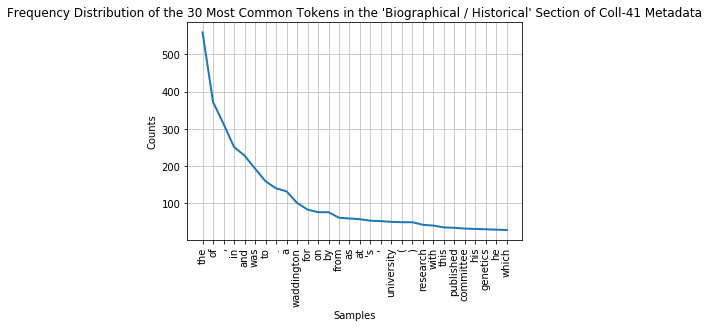

In [141]:
bh_fdist.plot(30, title="Frequency Distribution of the 30 Most Common Tokens in the 'Biographical / Historical' Section of Coll-41 Metadata")

Without stopwords (meaning no punctuation and non-content words such as "the" and "a"):

In [147]:
def removeStopWords(token_list):
    to_exclude = set(stopwords.words('english') + list(string.punctuation) + list(string.digits))
    filtered_token_list = [t for t in token_list if not t in to_exclude]
    after = len(filtered_token_list)
    return filtered_token_list

In [148]:
filtered_bht = removeStopWords(bh_tokens)
filtered_sct = removeStopWords(sc_tokens)
print(str(len(sc_tokens)-len(filtered_sct)) + " tokens removed from SC")
print(str(len(bh_tokens)-len(filtered_bht)) + " tokens removed from BH")

6514 tokens removed from SC
3493 tokens removed from BH


In [149]:
filtered_sc_fdist = FreqDist(filtered_sct)
filtered_bh_fdist = FreqDist(filtered_bht)

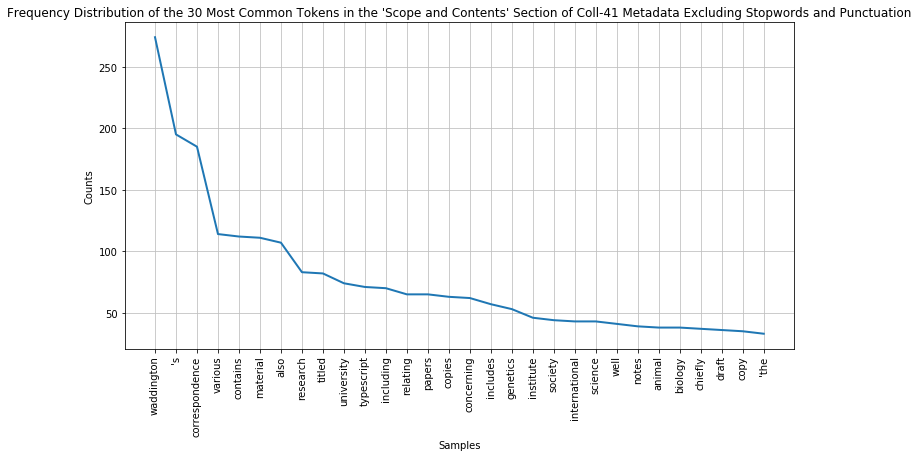

In [160]:
plt.figure(figsize=(12,6))
filtered_sc_fdist.plot(30, title="Frequency Distribution of the 30 Most Common Tokens in the 'Scope and Contents' Section of Coll-41 Metadata Excluding Stopwords and Punctuation")

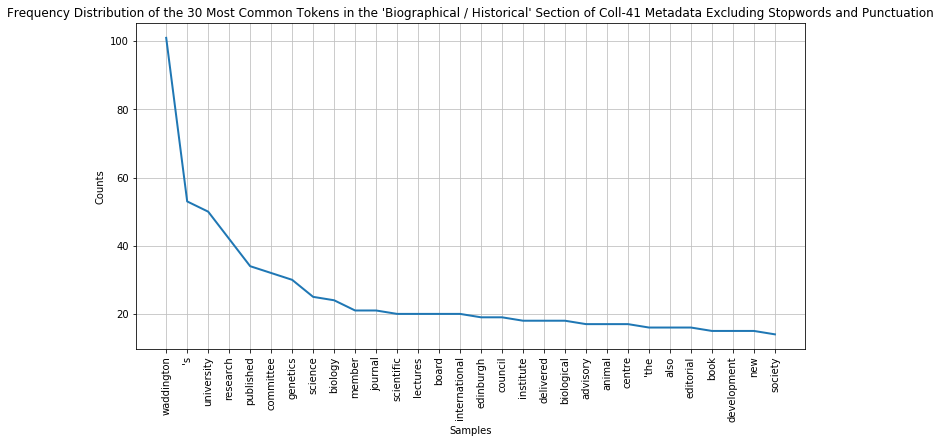

In [161]:
plt.figure(figsize=(12,6))
filtered_bh_fdist.plot(30, title="Frequency Distribution of the 30 Most Common Tokens in the 'Biographical / Historical' Section of Coll-41 Metadata Excluding Stopwords and Punctuation")

#### 3.2.2 Visualizing Tokens: Lexical Dispersion

In [162]:
# Use unfiltered token lists:
sc_texts = Text(sc_tokens)
bh_texts = Text(bh_tokens)

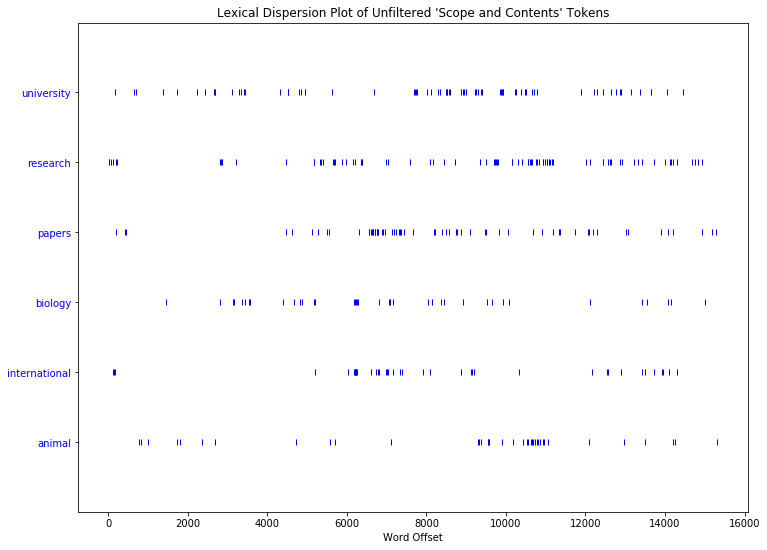

In [163]:
plt.figure(figsize=(12,9))
sc_targets = ["university", "research", "papers", "biology", "international", "animal"]
dispersion_plot(sc_texts, sc_targets, ignore_case=True, title="Lexical Dispersion Plot of Unfiltered 'Scope and Contents' Tokens")

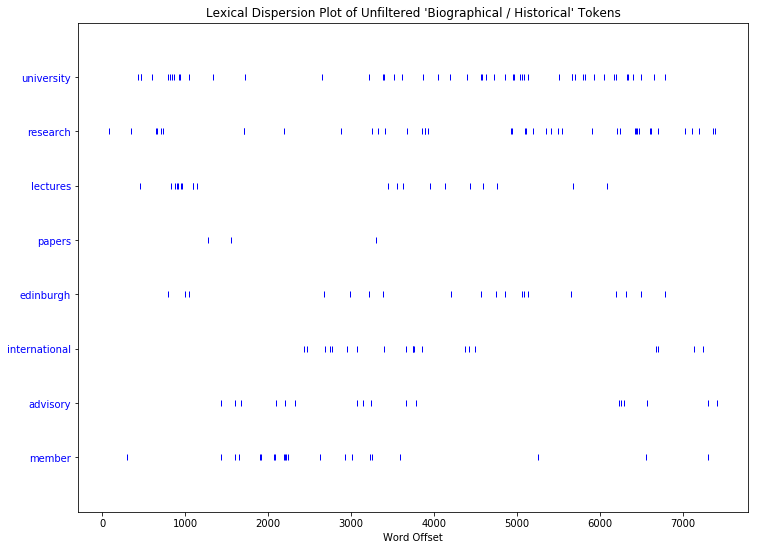

In [164]:
plt.figure(figsize=(12,9))
bh_targets = ["university", "research", "lectures", "papers", "edinburgh", "international", "advisory", "member"]
dispersion_plot(bh_texts, bh_targets, ignore_case=True, title="Lexical Dispersion Plot of Unfiltered 'Biographical / Historical' Tokens")

### 3.3 Collocating Tokens

First look for words that occur together **within 5 words** of one another...

In [169]:
bigram_measures = BigramAssocMeasures()
sc_finder = BigramCollocationFinder.from_words(filtered_sct, 5)
bh_finder = BigramCollocationFinder.from_words(filtered_bht, 5)

...at least **10 times** in the collection:

In [178]:
sc_finder.apply_freq_filter(10)
bh_finder.apply_freq_filter(10)

In [179]:
sc_finder.nbest(bigram_measures.likelihood_ratio, 10)   # other measures are available, specified top 10 be returned

[('waddington', "'s"),
 ('animal', 'genetics'),
 ('typescript', 'titled'),
 ('institute', 'animal'),
 ('royal', 'society'),
 ('also', 'includes'),
 ('material', 'contains'),
 ('meeting', 'papers'),
 ('file', 'contains'),
 ('institute', 'genetics')]

In [180]:
bh_finder.nbest(bigram_measures.likelihood_ratio, 10)

[('editorial', 'board'),
 ('animal', 'genetics'),
 ('waddington', "'s"),
 ('waddington', 'delivered')]

Note that the above analyses exclude stopwords.

### 3.4 Part-of-speech Tagging
#### 3.4.1 Scope and Contents' and 'Biographical / Historical' Descriptions
Now we'll include stopwords:

In [185]:
tagged_sc_tokens = nltk.pos_tag(sc_tokens)
tagged_sc_tokens[:5]

[('contains', 'NNS'),
 (':', ':'),
 ('laboratory', 'NN'),
 ('notebooks', 'NNS'),
 ('and', 'CC')]

In [186]:
tagged_bh_tokens = nltk.pos_tag(bh_tokens)
tagged_bh_tokens[:5]

[('waddington', 'NN'),
 ('worked', 'VBD'),
 ('with', 'IN'),
 ('joseph', 'NN'),
 ('and', 'CC')]

In [191]:
# Input: a list of tagged tokens and a part of speech
# Output: a list of all tokens tagged with the inputted parts of speech
# Note: inputting NN for singular noun will also return plural nouns (tagged NNS and NNPS)
def getPOS(tagged_token_list, pos):
    return [word for (word, tag) in tagged_token_list if (pos in tag)]

In [192]:
sc_nouns = getPOS(tagged_sc_tokens, "NN")
print(sc_nouns[:10])
print()
bh_nouns = getPOS(tagged_bh_tokens, "NN")
print(bh_nouns[:10])

['contains', 'laboratory', 'notebooks', 'bundles', 'research', 'notes', 'waddington', 'years', 'research', 'cambridge']

['waddington', 'joseph', 'needham', 'cambridge', 'articles', 'waddington', 'months', 'germany', 'professors', 'rockefeller']


#### 3.4.2 Visualizations

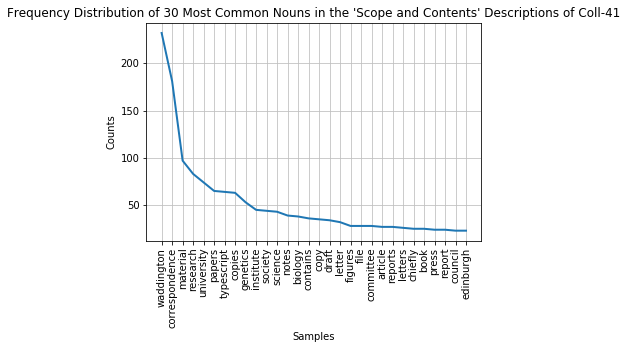

In [194]:
sc_nouns_fdist = FreqDist(sc_nouns)
sc_nouns_fdist.plot(30, title="Frequency Distribution of 30 Most Common Nouns in the 'Scope and Contents' Descriptions of Coll-41")

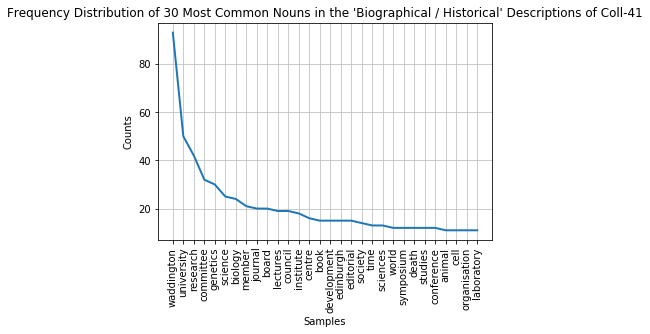

In [195]:
bh_nouns_fdist = FreqDist(bh_nouns)
bh_nouns_fdist.plot(30, title="Frequency Distribution of 30 Most Common Nouns in the 'Biographical / Historical' Descriptions of Coll-41")

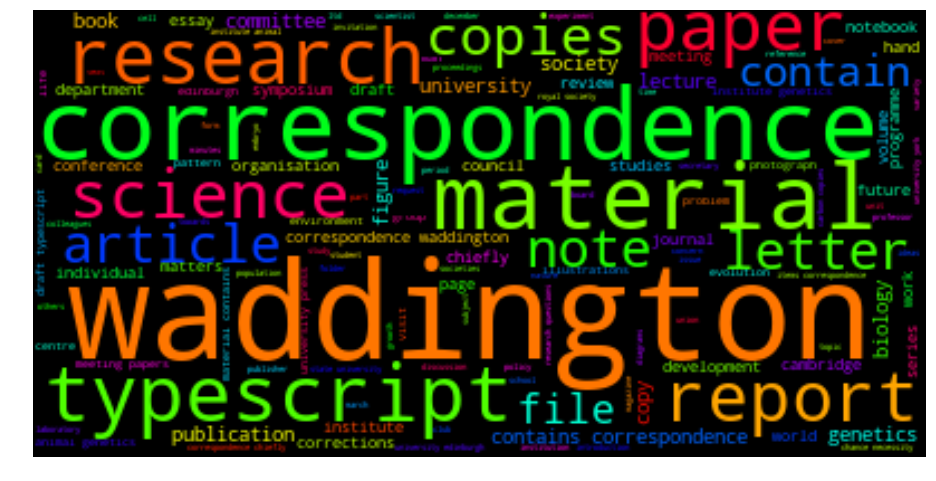

In [202]:
cloud = WordCloud(max_font_size=60, colormap="hsv").generate('  '.join(sc_nouns))
plt.rcParams["figure.figsize"] = (16,12)
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

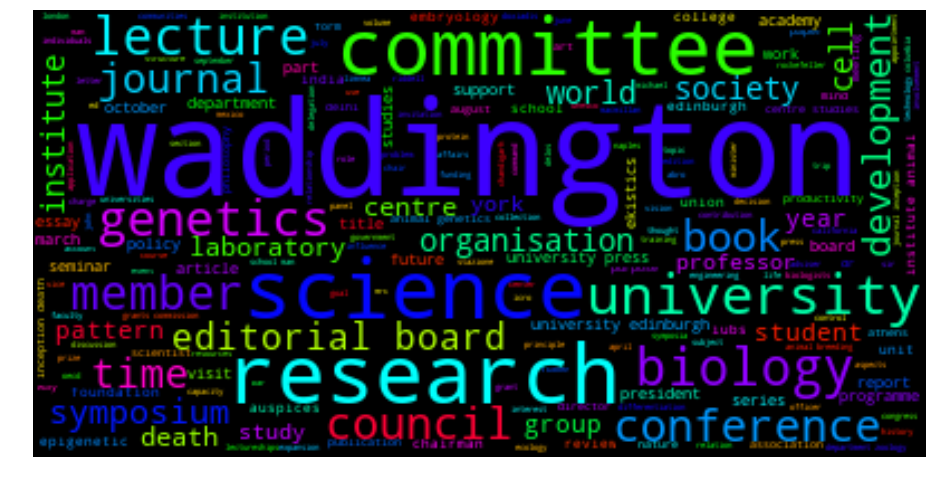

In [203]:
cloud = WordCloud(max_font_size=60, colormap="hsv").generate('  '.join(bh_nouns))
plt.rcParams["figure.figsize"] = (16,12)
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()